### import library

In [ ]:
import torch
import numpy as np
from torchvision import models
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import datetime
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

import copy
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets,transforms 
import torch.nn.functional as F

### Show data

In [15]:
data_train = pd.read_csv('./train.csv')
print(data_train)
data_train.head()

           fname          labels  is_valid
0     000005.jpg           chair      True
1     000007.jpg             car      True
2     000009.jpg    horse person      True
3     000012.jpg             car     False
4     000016.jpg         bicycle      True
...          ...             ...       ...
5006  009954.jpg    horse person      True
5007  009955.jpg            boat      True
5008  009958.jpg  person bicycle      True
5009  009959.jpg             car     False
5010  009961.jpg             dog     False

[5011 rows x 3 columns]


,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [16]:
data_test = pd.read_csv('./test.csv')
print(data_test)
data_test.head()

           fname                         labels
0     000001.jpg                     dog person
1     000002.jpg                          train
2     000003.jpg                     sofa chair
3     000004.jpg                            car
4     000006.jpg  pottedplant diningtable chair
...          ...                            ...
4947  009956.jpg                            cat
4948  009957.jpg                   person horse
4949  009960.jpg               motorbike person
4950  009962.jpg       chair person diningtable
4951  009963.jpg                            car

[4952 rows x 2 columns]


,fname,labels
0,000001.jpg,dog person
1,000002.jpg,train
2,000003.jpg,sofa chair
3,000004.jpg,car
4,000006.jpg,pottedplant diningtable chair


In [17]:
data_train.shape, data_test.shape

((5011, 3), (4952, 2))

In [ ]:
list_labels_split = [label.split(' ') for label in data_train['labels']]

In [19]:
labels = []
for i in list_labels_split:
  labels+=i

In [21]:
labels=set(labels)
print(len(labels))

20


In [23]:
labels = list(labels)
print(labels)

['cat', 'person', 'sheep', 'dog', 'train', 'horse', 'diningtable', 'chair', 'motorbike', 'car', 'aeroplane', 'bicycle', 'bottle', 'bus', 'cow', 'pottedplant', 'boat', 'bird', 'sofa', 'tvmonitor']


In [24]:
labels = ['dog', 'tvmonitor', 'person', 'bird', 'chair', 'car', 'sofa', 'sheep', 'bottle', 'bicycle', 'motorbike', 'bus', 'boat', 'pottedplant', 'horse', 'cat', 'aeroplane', 'cow', 'train', 'diningtable']

In [25]:
mul_class = labels

000005.jpg
chair
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


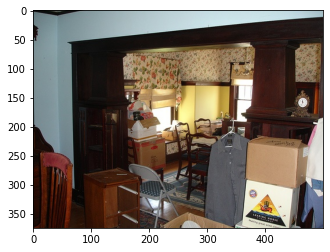

In [26]:
for i in range(len(data_train)):
  img = mpimg.imread('./train/'+str(data_train['fname'][i]))
  plt.imshow(img)
  print(data_train['fname'][i])
  print(data_train['labels'][i])
  vitri = 0
  lb = np.zeros(20)
  for j in mul_class:
    labels = data_train['labels'][i].split(' ')
    for k in labels:
      if k == j:
        lb[vitri]=1
    vitri+=1
  print(lb)
  break

In [15]:
import gc
gc.collect()

3060

### Custom dataset

In [ ]:
img_train = []
label_train = []

for i in range(len(data_train)):
  img = cv2.imread('./train/' + str(data_train['fname'][i]))
  img = cv2.resize(img,(300,300))
  vitri = 0
  lb = np.zeros(20)
  for j in mul_class:
    labels = data_train['labels'][i].split(' ')
    for k in labels:
      if k == j:
        lb[vitri]=1
    vitri+=1
  img = np.reshape(img, (3,300, 300))
  img_train.append(img)
  label_train.append(lb)

In [ ]:
validation_split = 0.2
dataset_size = len(img_train)

split = int(np.floor(dataset_size * validation_split))
indices = list(range(dataset_size))
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

img_train = torch.Tensor(img_train)
label_train = torch.Tensor(label_train)
train_data = TensorDataset(img_train,label_train)

# batch_size = 10
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(train_data, batch_size=batch_size, sampler=val_sampler)

### Build model CNN

In [40]:
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2),
    nn.Dropout(0.2),
    
    nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(2),
    nn.Dropout(0.2),
    
    nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(2),
    nn.Dropout(0.2),
    
    nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.MaxPool2d(2),
    nn.Dropout(0.2),
    
    nn.Flatten(),
    nn.Linear(256*18*18, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 20)
)
device = torch.device("cuda:0")
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

### Accuracy

##### acc1

In [47]:
def acc_train():
  correct = 0.
  total = 0.
  with torch.no_grad():
    for inputs, targets in train_loader:
      #move data to gpu
      inputs = inputs.to(device)
      #send data through the network and save outputs
      outputs = model(inputs)
      #map outputs to range of 0-1
     
      outputs = torch.tensor(outputs).cpu()
      #round up and down to either 1 or 0
      predicted = np.round(outputs) 
      #print(predicted)
      total += len(inputs)
      #print(len(inputs))
      for i in predicted:
        for j in targets:
            if torch.eq(i,j)==[True,  True, True,  True, True,  True, True, True,  True,  True,
         True,  True,  True,  True,  True, True,  True,  True,  True,  True]:
              correct += 1
            #print('ok')
      #correct += (predicted == labels).sum().item()
  accuracy = (100 * correct) / total
  print("Accuracy train: {}%".format(accuracy))

##### acc2

In [ ]:
correct = 0.
total = 0.

with torch.no_grad():
  for inputs, targets in train_loader:
    inputs = inputs.to(device)
    outputs = model(inputs)
    outputs = torch.sigmoid(outputs).cpu()       
    predicted = np.round(outputs) 
    #print(predicted)
    total += len(inputs)*batch_size*20
    for i in targets:
      for j in predicted:
        for k in torch.eq(i,j):
          if k == True:
            correct += 1

accuracy = 100 * correct / total

print("Accuracy: {}%".format(accuracy))

In [ ]:
def acc_val():
  correct = 0.
  total = 0.
  with torch.no_grad():
    for inputs, targets in train_loader:
      inputs = inputs.to(device)
      outputs = model(inputs)
      outputs = torch.sigmoid(outputs).cpu()      
      predicted = np.round(outputs) 
      #print(predicted)
      total += len(inputs)*batch_size*20
      #print(len(inputs))
      #calculate how many images were correctly classified
      for i in predicted:
        for j in targets:
         for k in torch.eq(i,j):
            if k == True:
                correct += 1
  accuracy = 100 * correct / total
  print("Accuracy val: {}%".format(accuracy))

In [257]:
acc_val()

Accuracy val: 92.11449239211774%


### Train

In [68]:
epocs = 50
train_losses = np.zeros(epocs)
test_losses = np.zeros(epocs)
for i in range(epocs):
  d0 = datetime.datetime.now()
  train_loss = []
  for inputs, targets in train_loader:
    
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    
    loss = criterion(outputs, targets)
    train_loss.append(loss.item())
    loss.backward()
    optimizer.step()
  
  train_losses[i] = np.mean(train_loss)
  test_loss = []
  for inputs, targets in val_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    test_loss.append(loss.item())

  test_losses[i] = np.mean(test_loss)
  dt = datetime.datetime.now() - d0
  print(f"epoc {i}/{epocs}, train loss={train_losses[i]}, test loss={test_losses[i]}")

epoc 0/50, train loss=0.7008567843066744, test loss=0.7005380552912516
epoc 1/50, train loss=0.7008504102904484, test loss=0.7005815283646659
epoc 2/50, train loss=0.7008408113304837, test loss=0.7006249006778474
epoc 3/50, train loss=0.700875241917918, test loss=0.700559137359498
epoc 4/50, train loss=0.7008393047102894, test loss=0.70052598629679
epoc 5/50, train loss=0.700828686534646, test loss=0.7005647832439059
epoc 6/50, train loss=0.700832152034182, test loss=0.7005115241285355
epoc 7/50, train loss=0.7008645048891881, test loss=0.7004977701202272
epoc 8/50, train loss=0.7008518387834389, test loss=0.7005824238534958
epoc 9/50, train loss=0.7008520300644803, test loss=0.7005028705748301
epoc 10/50, train loss=0.7008035834804475, test loss=0.7004707767849877
epoc 11/50, train loss=0.7008294774241657, test loss=0.7005201526104458
epoc 12/50, train loss=0.7008540117408175, test loss=0.7006071782301343
epoc 13/50, train loss=0.70081998128815, test loss=0.700465894880749
epoc 14/50,

### Save and load model

In [69]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted.pt') # Save

In [70]:
model = torch.jit.load('model_scripted.pt')
model.eval()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Conv2d)
  (1): RecursiveScriptModule(original_name=ReLU)
  (2): RecursiveScriptModule(original_name=BatchNorm2d)
  (3): RecursiveScriptModule(original_name=Conv2d)
  (4): RecursiveScriptModule(original_name=ReLU)
  (5): RecursiveScriptModule(original_name=BatchNorm2d)
  (6): RecursiveScriptModule(original_name=MaxPool2d)
  (7): RecursiveScriptModule(original_name=Dropout)
  (8): RecursiveScriptModule(original_name=Conv2d)
  (9): RecursiveScriptModule(original_name=ReLU)
  (10): RecursiveScriptModule(original_name=BatchNorm2d)
  (11): RecursiveScriptModule(original_name=Conv2d)
  (12): RecursiveScriptModule(original_name=ReLU)
  (13): RecursiveScriptModule(original_name=BatchNorm2d)
  (14): RecursiveScriptModule(original_name=MaxPool2d)
  (15): RecursiveScriptModule(original_name=Dropout)
  (16): RecursiveScriptModule(original_name=Conv2d)
  (17): RecursiveScriptModule(original_name=ReLU)
  (18)

### Check

In [71]:
!nvidia-smi

Mon Mar 14 04:22:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:03:00.0 Off |                  N/A |
|  0%   39C    P2    68W / 300W |   6443MiB / 11016MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:04:00.0 Off |                  N/A |
|  0%   39C    P8     8W / 300W |     11MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [72]:
import os

In [73]:
link = os.listdir('./train')

In [74]:
for i in range(10):
    img = cv2.imread('./train/' + link[i])
    print(img.shape)

(375, 500, 3)
(375, 500, 3)
(333, 500, 3)
(333, 500, 3)
(375, 500, 3)
(375, 500, 3)
(500, 375, 3)
(375, 500, 3)
(500, 333, 3)
(346, 500, 3)


In [ ]:
# !pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

### Pretrained model with resnet50

In [29]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std)
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [ ]:
batch_size = 10
num_workers = 2
dataset_sizes = { 'train': len(train_loader), 'test': len(val_loader) }
dataset_sizes

In [ ]:
validation_split = 0.2
dataset_size = len(img_train)

split = int(np.floor(dataset_size * validation_split))
indices = list(range(dataset_size))
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

img_train = torch.Tensor(img_train)
label_train = torch.Tensor(label_train)
train_data = TensorDataset(img_train,label_train)

train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers = num_workers)
val_loader = DataLoader(train_data, batch_size=batch_size, sampler=val_sampler, num_workers = num_workers)

In [190]:
dataset_size

5011

In [191]:
len(train_loader)

401

In [209]:
dataloaders = {
    'train': train_loader,
    'test': val_loader
}

In [210]:
print(mul_class)

['dog', 'tvmonitor', 'person', 'bird', 'chair', 'car', 'sofa', 'sheep', 'bottle', 'bicycle', 'motorbike', 'bus', 'boat', 'pottedplant', 'horse', 'cat', 'aeroplane', 'cow', 'train', 'diningtable']


In [211]:
device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")
print(device)

cuda


In [282]:
model = models.resnet50(pretrained=True)

In [283]:
ct = 0
for child in model.children():
  ct += 1
  if ct < 7:
      for param in child.parameters():
          param.requires_grad = False

In [231]:
# for param in model.parameters():
#     param.requires_grad = False

In [284]:
num_ftrs = model.fc.in_features
num_ftrs

2048

In [265]:
# model.fc = nn.Linear(num_ftrs, 20)

In [285]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

In [286]:
print(device)

cuda


In [295]:
model.to(device)

RecursiveScriptModule(
  original_name=ResNet
  (conv1): RecursiveScriptModule(original_name=Conv2d)
  (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
  (relu): RecursiveScriptModule(original_name=ReLU)
  (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
  (layer1): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=Bottleneck
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
      (conv2): RecursiveScriptModule(original_name=Conv2d)
      (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
      (conv3): RecursiveScriptModule(original_name=Conv2d)
      (bn3): RecursiveScriptModule(original_name=BatchNorm2d)
      (relu): RecursiveScriptModule(original_name=ReLU)
      (downsample): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(original_name=Conv2d)
        (1): RecursiveScriptModule(original_name=B

In [288]:
fc_inputs = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 20), 
    nn.Sigmoid()
)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [269]:
criterion        = nn.BCEWithLogitsLoss()
optimizer_ft     = optim.AdamW( model.parameters(), lr=0.005)
# optimizer_ft     = optim.SGD( model.parameters(), lr=0.005, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR( optimizer_ft, step_size=7, gamma=0.1)

### Train

In [289]:
epocs = 10
train_losses = np.zeros(epocs)
test_losses = np.zeros(epocs)
for i in range(epocs):
  train_loss = []
  for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer_ft.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    train_loss.append(loss.item())
    loss.backward()
    optimizer_ft.step()
  
  train_losses[i] = np.mean(train_loss)
  test_loss = []
  for inputs, targets in val_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    test_loss.append(loss.item())

  test_losses[i] = np.mean(test_loss)
  print(f"epoc {i}/{epocs}, train loss={train_losses[i]}, test loss={test_losses[i]}")

epoc 0/10, train loss=0.935866628204498, test loss=0.9352910276686791
epoc 1/10, train loss=0.9358293757474333, test loss=0.9352512932059789
epoc 2/10, train loss=0.9358328265739498, test loss=0.9350961434959185
epoc 3/10, train loss=0.9358482411377448, test loss=0.9352251887321472
epoc 4/10, train loss=0.9359071914691878, test loss=0.9350600968493094
epoc 5/10, train loss=0.9359020632401369, test loss=0.9352631757755091
epoc 6/10, train loss=0.9358835508698538, test loss=0.9351206321527462
epoc 7/10, train loss=0.935853224145504, test loss=0.935235843209937
epoc 8/10, train loss=0.935926290224318, test loss=0.9352929497709369
epoc 9/10, train loss=0.9358401521482967, test loss=0.9352098597158299


In [290]:
model_scripted = torch.jit.script(model) 
model_scripted.save('model_scripted.pt') 

In [291]:
model = torch.jit.load('model_scripted.pt')
model.eval()

RecursiveScriptModule(
  original_name=ResNet
  (conv1): RecursiveScriptModule(original_name=Conv2d)
  (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
  (relu): RecursiveScriptModule(original_name=ReLU)
  (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
  (layer1): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=Bottleneck
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
      (conv2): RecursiveScriptModule(original_name=Conv2d)
      (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
      (conv3): RecursiveScriptModule(original_name=Conv2d)
      (bn3): RecursiveScriptModule(original_name=BatchNorm2d)
      (relu): RecursiveScriptModule(original_name=ReLU)
      (downsample): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(original_name=Conv2d)
        (1): RecursiveScriptModule(original_name=B

In [294]:
correct = 0.
total = 0.

with torch.no_grad():
  for inputs, targets in train_loader:
    inputs = inputs.to(device)
    outputs = model(inputs)
    # print(outputs)
    # break
    outputs = torch.sigmoid(outputs).cpu()  
    # print(outputs)
    # break
    predicted = np.round(outputs) 
    print(predicted)
    print(targets)
    break
    total += len(inputs)*batch_size*20
    for i in targets:
      for j in predicted:
        for k in torch.eq(i,j):
          if k == True:
            correct += 1

accuracy = 100 * correct / total

print("Accuracy: {}%".format(accuracy))

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]])
tensor([[

ZeroDivisionError: float division by zero

In [64]:
pwd

'/home/tungnguyendinh/interns/users/hoa_hoangthi/data/pascal_2007'

000005.jpg
chair
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


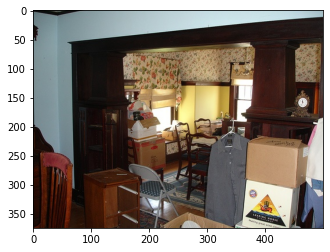

In [69]:
for i in range(len(data_train)):
  img = mpimg.imread('./train/'+str(data_train['fname'][i]))
  plt.imshow(img)
  print(data_train['fname'][i])
  print(data_train['labels'][i])
  vitri = 0
  lb = np.zeros(20)
  for j in mul_class:
    labels = data_train['labels'][i].split(' ')
    for k in labels:
      if k == j:
        lb[vitri]=1
    vitri+=1
  print(lb)
  break

### Visualizing models, data, and training with tensorboad

In [300]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [301]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/pc_2007')

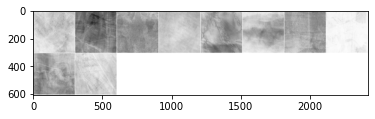

In [302]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('pc', img_grid)

In [ ]:
! tensorboard --logdir=runs --load_fast=false --bind_all

TensorFlow installation not found - running with reduced feature set.
TensorBoard 2.8.0 at http://labserver:6007/ (Press CTRL+C to quit)


In [109]:
writer.add_graph(model, images)
writer.close()

/home/tungnguyendinh/interns/env/lib/python3.7/site-packages/torch/jit/_trace.py:730: UserWarning: The input to trace is already a ScriptModule, tracing it is a no-op. Returning the object as is.
  "The input to trace is already a ScriptModule, tracing it is a no-op. Returning the object as is."


In [303]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np

writer = SummaryWriter()

for n_iter in range(100):
    writer.add_scalar('Loss/train', np.random.random(), n_iter)
    writer.add_scalar('Loss/test', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/train', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/test', np.random.random(), n_iter)

In [304]:
# helper functions

def images_to_probs(model, images):
    output = model(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(model, images, labels):
    preds, probs = images_to_probs(model, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [305]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer_ft.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_ft.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(train_loader) + i)

         
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(model, inputs, labels),
                            global_step=epoch * len(train_loader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training


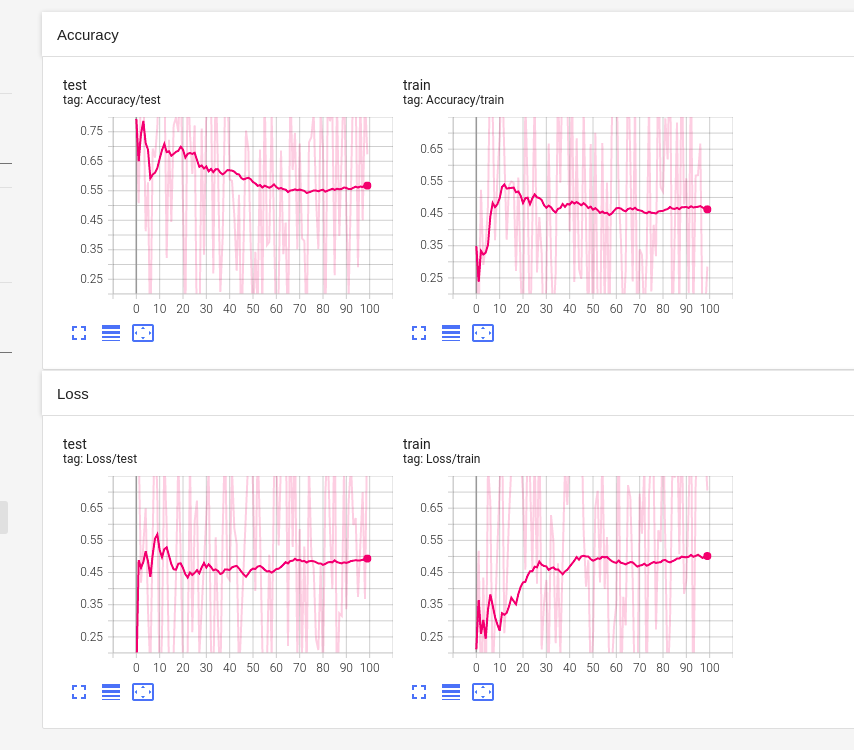